Epoch     0, Loss: 5.3414e+00
Epoch  1000, Loss: 6.1388e-04
Epoch  2000, Loss: 1.7500e-05
Epoch  3000, Loss: 1.0007e-05
Epoch  4000, Loss: 9.3715e-06
Epoch  5000, Loss: 8.7063e-06
Epoch  6000, Loss: 3.8349e-05
Epoch  7000, Loss: 7.3910e-06
Epoch  8000, Loss: 4.0584e-05
Epoch  9000, Loss: 1.0287e-05


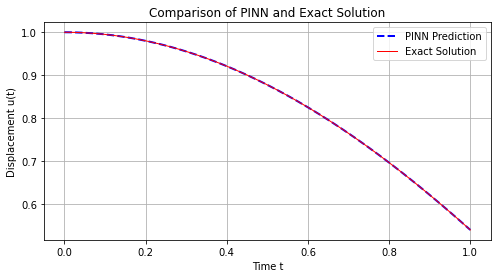

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define Physics-Informed Neural Network (PINN)
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 20),    # Input layer (1-dimensional)
            nn.Tanh(),            # Activation function
            nn.Linear(20, 20),    # Hidden layer
            nn.Tanh(),
            nn.Linear(20, 20),    # Hidden layer
            nn.Tanh(),
            nn.Linear(20, 1)      # Output layer (1-dimensional)
        )
    
    def forward(self, x):
        return self.layers(x)

# Compute loss function (includes differential equation residual and boundary conditions)
def compute_loss(model, x_internal):
    x_internal.requires_grad = True
    y = model(x_internal)
    
    # Compute first derivative
    dy_dx = torch.autograd.grad(
        outputs=y,
        inputs=x_internal,
        grad_outputs=torch.ones_like(y),
        create_graph=True
    )[0]
    
    # Compute second derivative
    d2y_dx2 = torch.autograd.grad(
        outputs=dy_dx,
        inputs=x_internal,
        grad_outputs=torch.ones_like(dy_dx),
        create_graph=True
    )[0]
    
    # Handle cases where x is close to 0 (avoid division by zero)
    epsilon = 1e-8
    x_safe = torch.where(x_internal < epsilon, epsilon, x_internal)
    
    # Compute differential equation residual
    residual = d2y_dx2 + (1/x_safe)*dy_dx + torch.cos(x_internal) + torch.sin(x_internal)/x_safe
    loss_equation = torch.mean(residual**2)
    
    # Compute boundary condition losses
    # Boundary condition at x=0
    x0 = torch.zeros(1, 1)
    y0 = model(x0)
    loss_bc0 = torch.mean((y0 - 1.0)**2)
    
    # Boundary condition at x=1
    x1 = torch.ones(1, 1)
    y1 = model(x1)
    loss_bc1 = torch.mean((y1 - torch.cos(torch.tensor(1.0)))**2)
    
    total_loss = loss_equation + loss_bc0 + loss_bc1
    return total_loss

# Training parameters
epochs = 10000       # Number of training epochs
lr = 0.001           # Learning rate
n_internal = 1000     # Number of internal points

# Initialize model and optimizer
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Generate training data (internal points uniformly distributed in (0,1] interval)
x_internal = torch.linspace(0.01, 1, n_internal).view(-1, 1)

# Training process
loss_history = []
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = compute_loss(model, x_internal)
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    if epoch % 1000 == 0:  # Print loss every 1000 epochs
        print(f'Epoch {epoch:5d}, Loss: {loss.item():.4e}')

# Plot prediction results compared with exact solution
x_test = torch.linspace(0, 1, 1000).view(-1, 1)
with torch.no_grad():
    y_pred = model(x_test).numpy()

y_exact = np.cos(x_test.numpy())

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
plt.figure(figsize=(8, 4))
plt.plot(x_test, y_pred, 'b--', linewidth=2, label='PINN Prediction')
plt.plot(x_test, y_exact, 'r-', linewidth=1, label='Exact Solution')
plt.xlabel('Time t')
plt.ylabel('Displacement u(t)')
plt.legend()
plt.title('Comparison of PINN and Exact Solution')
plt.grid(True)
plt.show()

In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
y_exact = y_exact.reshape(-1, 1)
y_p_pinn = y_pred
y_true = y_exact
R2_pinn = r2_score(y_p_pinn, y_true)
mae_pinn = mean_absolute_error(y_p_pinn, y_true)
rmse_pinn = mean_squared_error(y_p_pinn, y_true, squared=False)
inf_norm_pinn = np.linalg.norm(y_p_pinn - y_true, ord = np.inf)

print(f"R2_pinn: {R2_pinn}, mae_pinn: {mae_pinn}, rmse_pinn: {rmse_pinn}, inf_norm_pinn: {inf_norm_pinn}")

R2_pinn: 0.9999999815206188, mae_pinn: 1.62336236826377e-05, rmse_pinn: 1.887943835754413e-05, inf_norm_pinn: 3.319978713989258e-05


In [3]:
import numpy as np
import pandas as pd

data_to_save = pd.DataFrame({
    'x': x_test.flatten(),
    'y_pred_pinn': y_p_pinn.flatten(),
    'y_exact': y_true.flatten()
})

data_to_save.to_csv('pinn_11.csv', index=False)
print("pinn_11.csv")

数据已保存至 pinn_11.csv
